In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from Class_utils.parameters import file_paths,job_graph_par
from Class_utils.JobGraph import JobGraph
import ast
from Class_utils.FitnessFunctions import FitnessFunctions

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
%reload_ext autoreload
%autoreload 2

In [2]:
job_graph = JobGraph(file_paths, **job_graph_par)

Cache found loading...done


In [3]:
curricula = pd.read_csv("../outputs/test20k_curricula.csv").set_index("kId")

In [4]:
curricula

,qId,metadata,Education,Age,City,JobRange,Competences0,Competences1,Competences2,Competences3,...,Knowledge4,Knowledge5,Knowledge6,Language0,Language1,Language2,Language_level0,Language_level1,Language_level2,Experience
kId,,,,,,,,,,,,,,,,,,,,,
0,0,{'occ': '61d9270c-491d-438d-8d41-77ba2e0ef023'...,Master-D.,27,San Giovanni in Persiceto,50,write inspection reports,revise quality control systems documentation,read standard blueprints,negotiate with stakeholders,...,-,-,-,Spanish,German,English,Null,A1,C2,1
1,0,{'occ': '61d9270c-491d-438d-8d41-77ba2e0ef023'...,Master-D.,30,Castro dei Volsci,70,write an evaluation reports,revise quality control systems documentation,manufacturing quality standards monitoring,manage health and safety standards,...,continuous improvement strategies,-,-,German,English,-,A1,C2,-,0
2,0,{'occ': 'c5b45ebe-0e9f-4bc4-9563-7fdf31115e53'...,Master-D.,31,Mezzanino,80,use testing equipment,extract information from standard blueprints,"manage compliance with health, safety, and hyg...",coordinate performance tests,...,principles of electricity,-,-,Italian,German,English,C2,Null,C1,1
3,0,{'occ': 'b0ad8659-0410-4b5b-9466-a90f8b3cdac9'...,Master-D.,27,Sant'Arpino,80,write inspection reports,revise quality control systems documentation,"ensure compliance with health, safety, and hyg...",-,...,-,-,-,Italian,English,-,Null,C2,-,1
4,0,{'occ': 'b0ad8659-0410-4b5b-9466-a90f8b3cdac9'...,Master-D.,28,Robecco sul Naviglio,80,write inspection reports,assembly line teamwork,support implementation of quality management s...,amend quality control systems documentation,...,-,-,-,German,English,-,Null,C2,-,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19829,199,{'occ': 'a99b38bc-6e71-4bef-b127-0f2b5e357815'...,Degree,26,Comacchio,30,train employees,perform project management,manage keys for data protection,implement ICT risk management,...,ICT system user requirements,ICT network security risks,-,Italian,German,French,C1,Null,Null,3
19830,199,{'occ': '4e3fede9-5522-4624-91bc-b59c79fada02'...,Master-D.,40,Pavia,30,deal with CAE systems,apply CAD software,erect the controller of a machine,prepare production processes,...,schematics,-,-,Italian,French,-,C2,B2,-,1
19831,199,{'occ': '8908d5aa-ac58-465e-9b75-7e02ed4af3a9'...,Degree,43,Savoia di Lucania,70,oversee software systems used in dispatching,collaborate with port users,implement cost-effective cargo handling strate...,ensure compliance with port regulations,...,maritime telecommunications operations,freight transport methods,-,Spanish,French,English,B2,Null,Null,1


In [5]:
curricula_md = pd.json_normalize(curricula["metadata"].apply(ast.literal_eval))
curricula_md.index.rename("kId", inplace=True)

In [6]:
comp_columns = ["Competences"+str(i) for i in range(0, 6 + 1)]
know_columns = ["Knowledge"+str(i) for i in range(0, 6 + 1)]

In [7]:
counter = np.zeros((2, 5))
total = np.zeros((2, 5))
qId_error_comp,qId_error_know = [],[]


for kId, cv in tqdm(curricula.iterrows(),total=len(curricula)):

    comp = FitnessFunctions.filter(cv[comp_columns].to_list())
    un_comp, amb_comp = job_graph.skill_standardize(comp)
    de_amb_comp = job_graph.solve_ambiguous(amb_comp, un_comp)
    
    real_uris = curricula_md.loc[kId, "uri_competences"]
    total[0, len(amb_comp)] += 1
    equal_ = 0 if set(un_comp) | set(de_amb_comp)  ==  set(real_uris) else 1
    if equal_ == 1:
        counter[0, len(amb_comp)] += 1
        qId_error_comp.append(kId)

    know = FitnessFunctions.filter(cv[know_columns].to_list())
    un_know, amb_know = job_graph.skill_standardize(know)
    de_amb_know = job_graph.solve_ambiguous(amb_know, un_know)

    real_uris = curricula_md.loc[kId, "uri_knowledge"]
    total[1, len(amb_know)] += 1
    equal_ = 0 if set(un_know) | set(de_amb_know)  ==  set(real_uris) else 1
    if equal_ == 1:
        counter[1, len(amb_know)] += 1
        qId_error_know.append(kId)


100%|██████████| 19834/19834 [00:18<00:00, 1073.55it/s]


In [8]:
counter

array([[  0., 239.,  61.,   7.,   0.],
       [  0., 600., 128.,  33.,   1.]])

In [9]:
total

array([[1.6456e+04, 3.0500e+03, 3.0500e+02, 2.2000e+01, 1.0000e+00],
       [1.5667e+04, 3.7530e+03, 3.6500e+02, 4.8000e+01, 1.0000e+00]])

In [10]:
total_, errors_ = list(total.sum(axis=0)), list(counter.sum(axis=0))
dt = pd.DataFrame(
    {
        "# ambiguous":[*range(len(errors_))],
        "perc": [e/t if t > 0 else 0 for t, e in zip(total_,errors_)],
        "%": [str(format(e/t, '.4f'))+" %" if t > 0 else "0.0000 %" for t, e in zip(total_,errors_)]
    })
dt.drop(0,inplace=True)
dt

,# ambiguous,perc,%
1,1,0.123328,0.1233 %
2,2,0.282090,0.2821 %
3,3,0.571429,0.5714 %
4,4,0.500000,0.5000 %


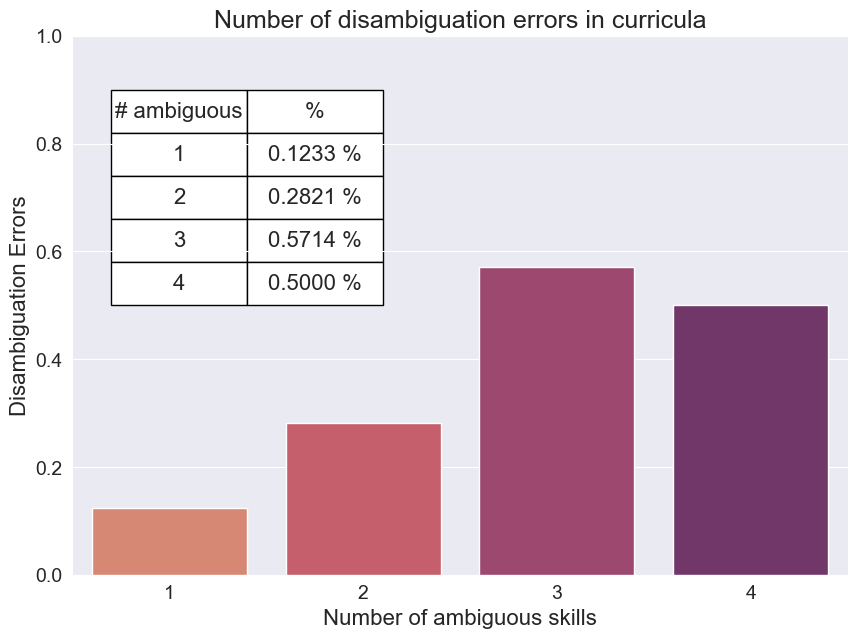

In [11]:
_, axs = plt.subplots(figsize=(10, 7))

sns.barplot(x="# ambiguous", y="perc", palette="flare",data=dt, ax=axs)
sns.despine(left=True, bottom=True)
axs.set_title('Number of disambiguation errors in curricula', fontsize=18)
axs.set_xlabel('Number of ambiguous skills', fontsize=16)
axs.set_ylabel('Disambiguation Errors', fontsize=16)
axs.tick_params(axis='both', labelsize=14)
axs.set_ylim([0, 1])

table = plt.table(cellText=dt[["# ambiguous","%"]].values, colLabels=dt[["# ambiguous","%"]].columns,
                  cellLoc='center', bbox=[0.05, 0.5, 0.35, 0.4], loc='upper right')

table.auto_set_font_size(False)
table.set_fontsize(16)
plt.show()